# COMENTARIOS

* No cambiar a category las columanas porque no puedo ver la corr. (https://stackoverflow.com/questions/67252076/correlation-matrix-in-pandas-doesnt-take-some-column-into-consideration)    

# Información 

1. Descricpción del problema
1. Data cleaning y formatting
1. EDA
3. Feature selecction y engenieering
4. Comparación de modelos
5. Hyperparameter tunning sobre el mejor modelo
6. Evaluacion
7. Interpretación
8. Conclusión

OBJETIVO: Determinar que personas van a ser morosos en los prestamos

# 0. IMPORTACIONES Y SETEOS

## Imports 

In [1]:
# Pandas y numpy para manipulación
import pandas as pd
import numpy as np
# Librerias para gráficos 
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de DS
import DSImplementation as dsimp
# Funciones para analizar valores faltantes 
import missingno as msno

## Seteos

In [2]:
# Para evitar que salgan advertencias por usar dataframes sin un .copy()
pd.options.mode.chained_assignment = None

# Se setea un maximo de 60 columnas para visualizar
pd.set_option('display.max_columns', 60)

# Matplotlib visualización en la celda
%matplotlib inline

# 1. DESCRIPCIÓN DEL PROBLEMA 

* Fecha_Pago: fecha cuando la persona pago la cuota del prestamo. Es diferente a la fecha de acreditación. 
* Vencimiento: fecha en la cual vence el prestamos, y hay algunos prestamos con doble fecha de vencimiento. El primer vencimiento es siempre el 20 y el segundo es el 30. No todos los tipos de linea de prestamos admiten segundo vencimiento. 
* Tipo de prestamo: numero de ID, cada ID corresponde a un barrio diferente. El IVC construye de a un barrio por vez. Puede pasar que para un mismo barrio puedo tener diferentes tipo de prestamo (linea de prestamo). 
* Numero_Prestamo: Es el ID del prestamo. Es unico y no se repite
* Total_prestamo[CALCULADO]: el total que tiene que pagar para el prestamos, no es lo que le falta. Se calcula como suma de capital, interes y gastos.
* Total_cutas: cantidad de cuotas que tiene el prestamo
* Numero de cuota: es la cuota que se esta pagando. Se permite saltear cuotas, es decir, se puede no pagar la 16 y pagar la 17. De esta forma la persona quedaria adeudnado la cuota 16.
* Pago: monto del recibo de pago. Cada pago puede no corresponder a una unica cuota. Puede ser una de cuatro opciones: Pago de cuota completa, pago parcial de cuota, adelanto de cuota, pago completo del prestamo. 
* Genero: Masculino o Femenino, binario
* Edad[CALCULADO]: la edad del que pide el prestamo
* Paga_en_termino [CALCULADO]: si pago antes del vencimiento. A partir de 2021 se introdujo segundo vencimiento (el 30). 1 es que esta en termino, 0 que no pago en termino
* Refinaciado [CALCULADO] : indica si el prestamo fue refinanciado en el pasado. Es decir, cuando se reestructura la deuda. 1 es que esta refinanciado, 0 que no esta refinanciado. 


Nuestro campo targe es "Pagado en termino" para evaluar si el mes que viene me van a pagar o no 

Columnas a agregar:

* Numerico indicando tipo de pago. 1: Pago de cuota completa, 2: pago parcial de cuota, 3: adelanto de cuota, 4: pago completo del prestamo
* Faltante total a pagar: el monto que falta pagar del prestamo

Preguntas:

* Agrego columnas que traiga cantidad de cuotas no pagas en terminas para ese prestamo por esa persona?


# 2. DATA CLEANING Y FORMATING

## Carga del dataset a trabajar 

In [5]:
# Se carga el dataset
data_train = pd.read_csv('Data/DATASET TP4 VERSION 7 2015-2019 correjido.csv', sep=';')
data_train.head(5)

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
0,02/01/2015,20/02/2015,974,1091205,16090435.0,"181874,40",240,119,"0,50","623,82","0,34",Masculino,42.0,1,0
1,02/01/2015,20/01/2015,974,1091205,16090435.0,"181874,40",240,118,"0,51","623,82","0,34",Masculino,42.0,1,0
2,02/01/2015,20/03/2015,974,1091205,16090435.0,"181874,40",240,120,"0,50","623,82","0,34",Masculino,42.0,1,0
3,02/01/2015,20/01/2015,955,1095467,2115837.0,"14180,19",360,102,"0,72","45,26","0,32",Femenino,95.0,1,0
4,02/01/2015,20/02/2015,877,10991758,25238393.0,"551452,31",360,45,"0,88","993,63","0,18",NaN,45.0,1,0


## Tipo de datos, valores faltantes y valores nulos 

### Valores nulos y tipo de datos 

In [6]:
# Cantidad de datos totales
rows_n, cols_n = data_train.shape
print(rows_n, cols_n)

763877 15


In [7]:
# Se observa los tipos de columna
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763877 entries, 0 to 763876
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Fecha_Pago                          763877 non-null  object 
 1   Vencimiento                         763877 non-null  object 
 2   Tipo_Prestamo                       763877 non-null  int64  
 3   Numero_Prestamo                     763877 non-null  int64  
 4   DNI                                 649441 non-null  float64
 5   Total_Prestamo                      763877 non-null  object 
 6   Total_cuotas                        763877 non-null  int64  
 7   Numero_Cuota                        763877 non-null  int64  
 8   Porcentaje_de_cuotas_faltantes      763877 non-null  object 
 9   Pago                                763877 non-null  object 
 10  Porcentaje_de_cuota_sobre_prestamo  763877 non-null  object 
 11  genero                    

### Quitan filas duplicadas de filas duplicadas 

In [18]:
data_train['Porcentaje_de_cuota_sobre_prestamo'].str.replace(',','.').astype('float').sort_values(ascending=False)[:10]

164268    136.43
164167    105.56
225983    105.17
169137    104.74
179342    104.44
248147    102.64
168213    102.42
192836    102.23
177175    101.91
195755    101.75
Name: Porcentaje_de_cuota_sobre_prestamo, dtype: float64

In [14]:
data_train.loc[data_train['Porcentaje_de_cuota_sobre_prestamo']=='136,43']

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
164268,04/03/2016,20/04/2009,428,1059770,NaN,"16,47",1,1,"0,00","22,47","136,43",NaN,NaN,0,0


In [20]:
data_train.loc[data_train['Porcentaje_de_cuota_sobre_prestamo']=='105,56']

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
164167,04/03/2016,21/05/2012,428,10992674,29185669.0,"108,17",1,1,"0,00","114,18","105,56",Femenino,41.0,0,0


In [ ]:
data_train.loc[data_train['Porcentaje_de_cuota_sobre_prestamo']=='105,56']

Se sacan las filas duplicadas sin contar la edad y el genero

In [23]:
data_train = data_train.drop(["Unnamed: 15"], axis=1)

In [30]:
columns = list(set(data_train.columns)-{'Edad', 'genero'})
data_train_aux = data_train.loc[:, columns]
indices = data_train_aux.loc[data_train_aux.duplicated(keep=False),:].index
data_train.iloc[indices, :].head(30).sort_values(by=['DNI','Numero_Cuota'])
# data_train.loc[data_train.duplicated(keep=False),:]

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
33,02/01/2015,20/01/2015,930,1087517,4137932.0,"56482,14",240,177,"0,26","221,63","0,39",NaN,NaN,1,0
36,02/01/2015,20/01/2015,930,1087517,4137932.0,"56482,14",240,177,"0,26","221,63","0,39",Masculino,50.0,1,0
34,02/01/2015,20/02/2015,930,1087517,4137932.0,"56482,14",240,178,"0,26","221,63","0,39",Masculino,50.0,1,0
37,02/01/2015,20/02/2015,930,1087517,4137932.0,"56482,14",240,178,"0,26","221,63","0,39",NaN,NaN,1,0
35,02/01/2015,20/03/2015,930,1087517,4137932.0,"56482,14",240,179,"0,25","221,63","0,39",Masculino,50.0,1,0
38,02/01/2015,20/03/2015,930,1087517,4137932.0,"56482,14",240,179,"0,25","221,63","0,39",NaN,NaN,1,0
30,02/01/2015,20/02/2015,435,1062065,4229882.0,"43340,31",300,266,"0,11","154,88","0,36",NaN,NaN,1,0
31,02/01/2015,20/02/2015,435,1062065,4229882.0,"43340,31",300,266,"0,11","154,88","0,36",Femenino,83.0,1,0
164,03/01/2015,20/01/2015,978,1091590,4706401.0,"34470,34",120,102,"0,15","210,79","0,61",Masculino,43.0,1,0
165,03/01/2015,20/01/2015,978,1091590,4706401.0,"34470,34",120,102,"0,15","210,79","0,61",NaN,NaN,1,0


 ### Valores faltantes 

In [13]:
dsimp.missing_values_table(data_train)

Your selected dataframe has 16 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Unnamed: 15,763877,100.0
genero,326688,42.8
Edad,299550,39.2
DNI,114436,15.0


Observamos muchos valores faltantes de Genero y Edad.

La edad esta llenada a menor porque cargaron mal los datos, de pajeros ponen 1900. 

<AxesSubplot:>

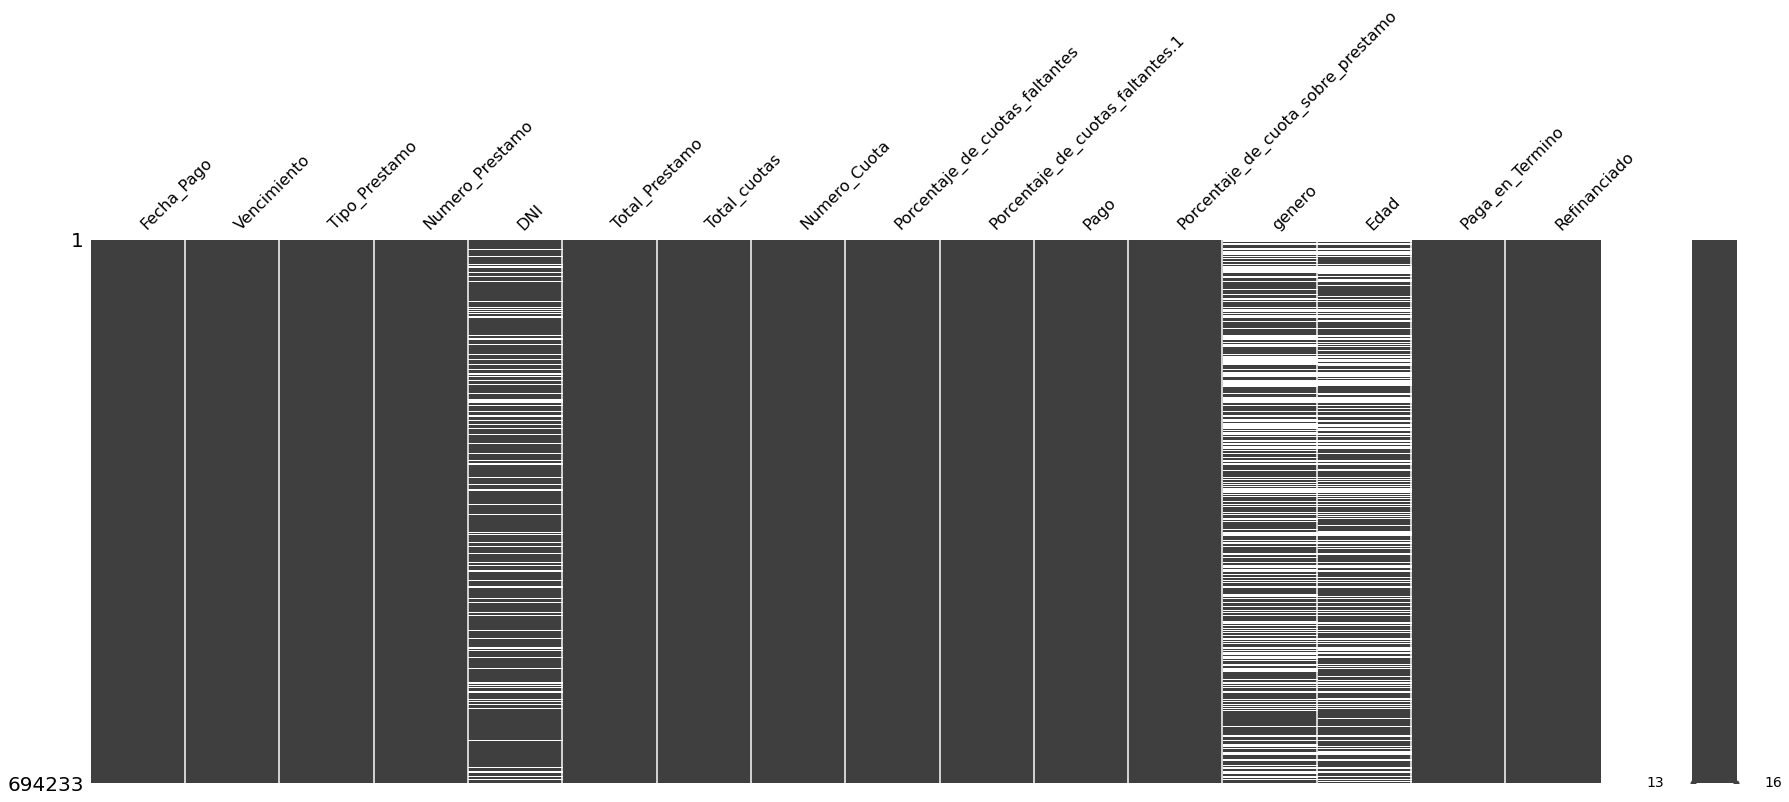

In [15]:
msno.matrix(data_train, figsize=(30,10))

In [13]:
# Se quitan valores faltantes
data_train = data_train.dropna()

In [14]:
dsimp.missing_values_table(data_train)

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [15]:
print('cantidad de filas perdidas: {} \ncantidad de del dataset: {}'.format(rows_n - data_train.shape[0], data_train.shape[0]))

cantidad de filas perdidas: 391479 
cantidad de del dataset: 372398


 ### Análsisi de los tipo de de columna

In [16]:
# Columnas que son de tipo objeto
data_train.select_dtypes(include="object").columns

Index(['Fecha_Pago', 'Vencimiento', 'Porcentaje_de_cuota_sobre_prestamo',
       'genero'],
      dtype='object')

Observamos que las columnas  "Fecha de pago", "Vencimiento" y "Genero" son de tipo objetvo. Vamos a transformarlos. Tambien observamos que Edad se encuentra como un float

In [18]:
# Columnas que son de tipo float
data_train.select_dtypes(include="float").columns

Index(['DNI', 'Total_Prestamo', 'Porcentaje_de_cuotas_faltantes',
       'Porcentaje_de_cuotas_faltantes.1', 'Pago', 'Edad'],
      dtype='object')

In [19]:
# Columnas que son de tipo int
data_train.select_dtypes(include="int").columns

Index(['Tipo_Prestamo', 'Numero_Prestamo', 'Total_cuotas', 'Numero_Cuota',
       'Paga_en_Termino', 'Refinanciado'],
      dtype='object')

In [36]:
data_train['Porcentaje_de_cuota_sobre_prestamo']

0         0.3430
1         0.3430
2         0.3430
3         0.3192
5         0.5472
           ...  
763870    0.4347
763873    0.0026
763874    0.2647
763875    0.2006
763876    0.0059
Name: Porcentaje_de_cuota_sobre_prestamo, Length: 372398, dtype: object

In [41]:
# se sacan los 1.000.000
serie_foo = data_train['Porcentaje_de_cuota_sobre_prestamo'].str.replace('.', '').astype('float')/10000 < 1
data_train = data_train.loc[serie_foo]

C:\Users\Fran\AppData\Local\Temp/ipykernel_12076/313540628.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie_foo = data_train['Porcentaje_de_cuota_sobre_prestamo'].str.replace('.', '').astype('float')/10000 < 1


 ### Parseo de datos date

In [42]:
# Se convierten las columnas de tipo object
columns_dates = ['Fecha_Pago', 'Vencimiento']
data_train[columns_dates] =data_train[columns_dates].astype('datetime64[ns]')

 ### Parseo de datos cateogricos

In [44]:
# Analisis de posibles variables categoricas
columns_categorical = ['Tipo_Prestamo','Paga_en_Termino', 'Refinanciado', 'genero'] 

# Se chequea que sean variables categoricas 
for col in columns_categorical:
    print ('{}: {}'.format(col, len(data_train[col].unique())))
    

Tipo_Prestamo: 214
Paga_en_Termino: 2
Refinanciado: 2
genero: 2


In [50]:
# se convierten a columnas categoricas 
data_train[columns_categorical] = data_train[columns_categorical].astype("category")

 ### Parseo de datos a float

# 3. EDA

### Estadisticas basicas

In [51]:
data_train.describe(include='all', datetime_is_numeric=True)

,Fecha_Pago,Vencimiento,Tipo_Prestamo,Numero_Prestamo,DNI,Total_Prestamo,Total_cuotas,Numero_Cuota,Porcentaje_de_cuotas_faltantes,Porcentaje_de_cuotas_faltantes.1,Pago,Porcentaje_de_cuota_sobre_prestamo,genero,Edad,Paga_en_Termino,Refinanciado
count,304607,304607,304607.0,3.046070e+05,3.046070e+05,3.046070e+05,304607.000000,304607.000000,304607.000000,304607.000000,304607.000000,304607,304607,304607.000000,304607.0,304607.0
unique,NaN,NaN,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9625,2,NaN,2.0,2.0
top,NaN,NaN,954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3157,Masculino,NaN,1.0,0.0
freq,NaN,NaN,62939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1389,164324,NaN,171147.0,298795.0
mean,2017-08-23 15:28:55.795960064,2017-04-15 10:29:07.366278656,NaN,6.909977e+06,2.907649e+07,2.312523e+05,306.487175,81.128487,0.999081,0.721428,530.790895,NaN,NaN,54.390575,NaN,NaN
min,2015-01-02 00:00:00,1999-12-20 00:00:00,NaN,1.070590e+05,9.000000e+00,1.130600e+03,2.000000,1.000000,0.000000,0.000000,1.010000,NaN,NaN,3.000000,NaN,NaN
25%,2016-05-05 00:00:00,2016-01-20 00:00:00,NaN,1.093351e+06,1.226122e+07,2.669577e+04,240.000000,33.000000,1.000000,0.613900,50.640000,NaN,NaN,43.000000,NaN,NaN
50%,2017-12-07 00:00:00,2017-06-20 00:00:00,NaN,1.000197e+07,2.023246e+07,7.611568e+04,360.000000,78.000000,1.000000,0.738900,189.780000,NaN,NaN,50.000000,NaN,NaN
75%,2018-12-06 00:00:00,2018-10-22 00:00:00,NaN,1.099723e+07,2.793347e+07,1.848749e+05,360.000000,123.000000,1.000000,0.869400,438.710000,NaN,NaN,63.000000,NaN,NaN
max,2019-12-31 00:00:00,2025-11-20 00:00:00,NaN,2.000135e+07,9.584585e+07,7.951995e+06,999.000000,360.000000,1.000000,0.998900,21304.730000,NaN,NaN,143.000000,NaN,NaN


### Analisis variable objetivo

Primero se inicia analizando la variable target para analizar si se encuentra balanceado el data set. Observamos que sigue una distribución uniforme, con lo cual no vamos a necesitar recurrir a SMOTE para balancearlo. Concluimos que:

* El dataset se encuentra balanceado
* No se observa presencia de anomalias o outliers

Text(0.5, 1.0, 'Balance de la variable objetivo "Paga_en_Termino"')

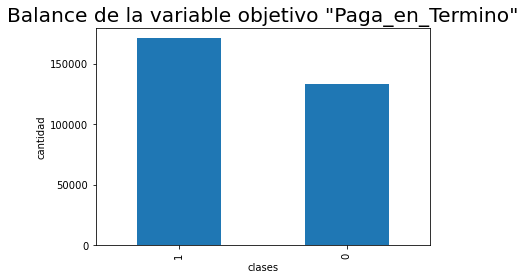

In [52]:
# Grafico
data_train.Paga_en_Termino.value_counts().plot(kind='bar')
# Seteos del gráfico
plt.style.use('fivethirtyeight')
plt.xlabel('clases')
plt.ylabel ('cantidad')
plt.title('Balance de la variable objetivo "Paga_en_Termino"')

In [56]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304607 entries, 0 to 763876
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Fecha_Pago                          304607 non-null  datetime64[ns]
 1   Vencimiento                         304607 non-null  datetime64[ns]
 2   Tipo_Prestamo                       304607 non-null  category      
 3   Numero_Prestamo                     304607 non-null  int64         
 4   DNI                                 304607 non-null  float64       
 5   Total_Prestamo                      304607 non-null  float64       
 6   Total_cuotas                        304607 non-null  int64         
 7   Numero_Cuota                        304607 non-null  int64         
 8   Porcentaje_de_cuotas_faltantes      304607 non-null  float64       
 9   Porcentaje_de_cuotas_faltantes.1    304607 non-null  float64       
 10  Pago    

### Análisis de variables descriptivas  

<Figure size 432x288 with 0 Axes>

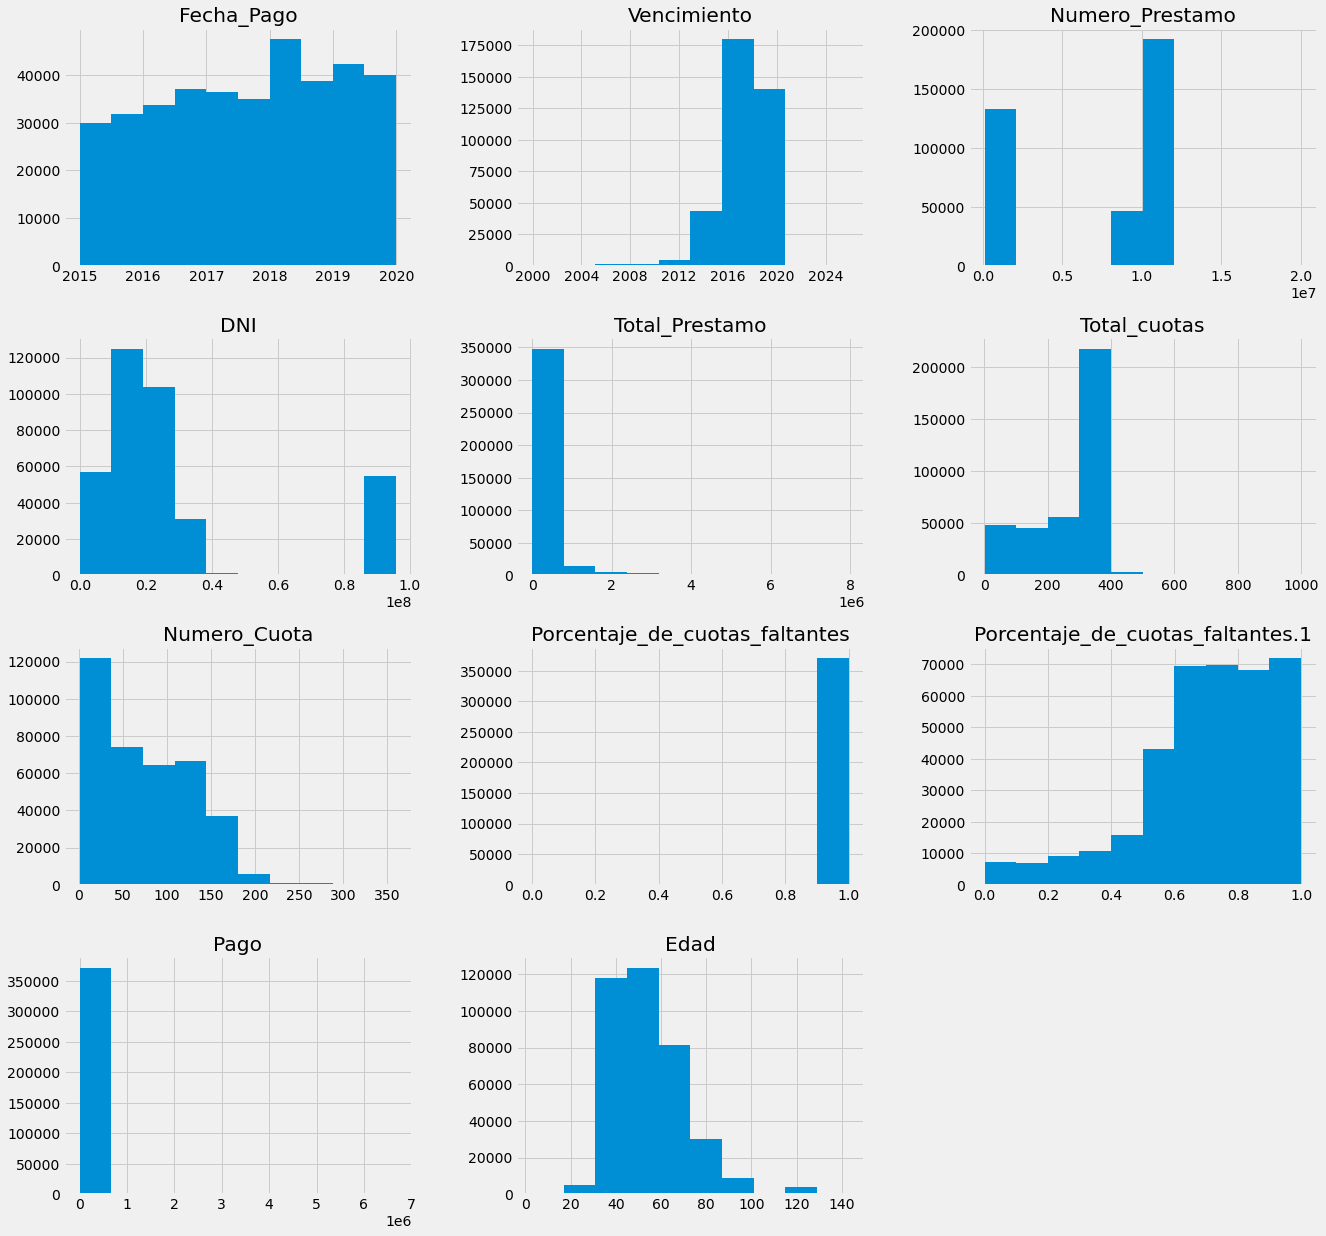

In [35]:
f = plt.figure() 
data_train.hist(figsize=(20,20))
plt.ticklabel_format(style='plain', axis='x')

# data_train.hist(ax=f.gca(), figsize=(20,20))
plt.show()

### Analisis con la variable objetivo

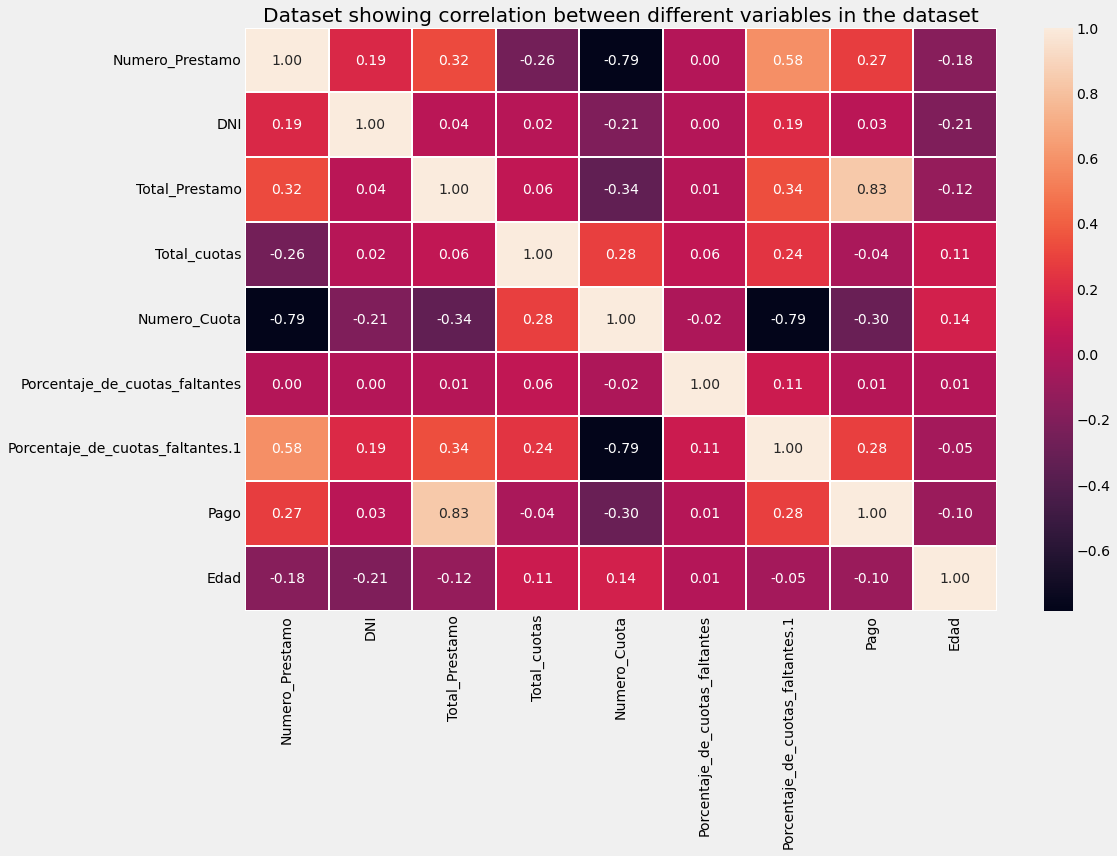

In [53]:
corr = data_train.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.2,)
plt.title('Dataset showing correlation between different variables in the dataset')
plt.show()

In [54]:
price_range_corr =  corr.Paga_en_Termino.sort_values(ascending = False)
price_range_corr_top = price_range_corr.head(6)
price_range_corr_bottom = price_range_corr.tail()
print ('top corr: \n{} \n\nbottom corr: \n{}'.format(price_range_corr_top, price_range_corr_bottom))

AttributeError: 'DataFrame' object has no attribute 'Paga_en_Termino'

In [ ]:
sns.pairplot(data_train, hue='Paga_en_Termino')

In [ ]:
sns.pairplot(data_train[price_range_corr_top.index], hue='price_range')

<Figure size 1080x1080 with 0 Axes>

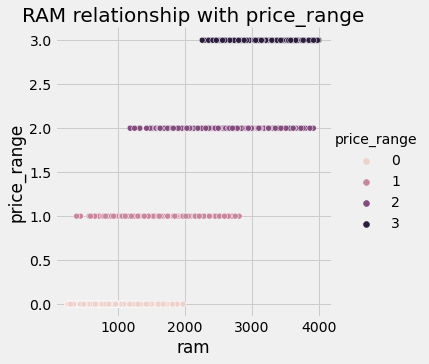

<Figure size 1080x1080 with 0 Axes>

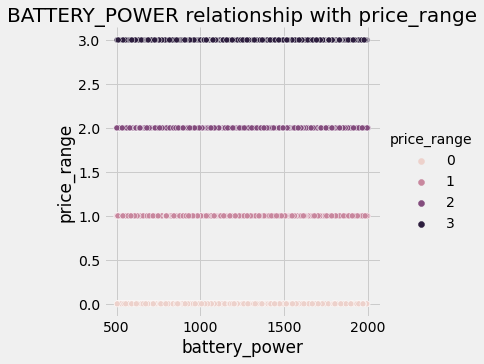

<Figure size 1080x1080 with 0 Axes>

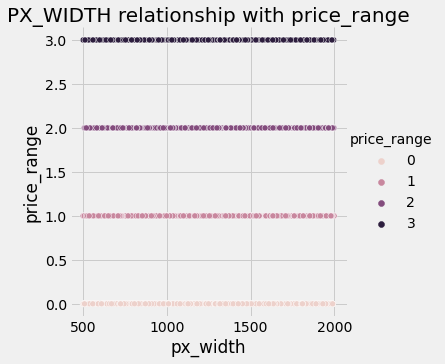

<Figure size 1080x1080 with 0 Axes>

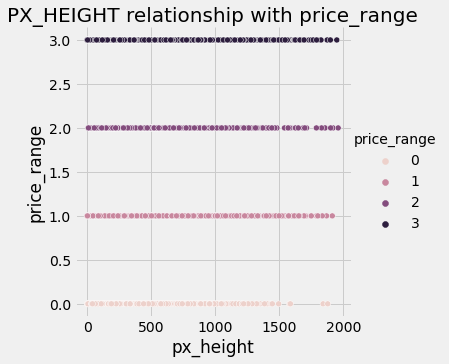

<Figure size 1080x1080 with 0 Axes>

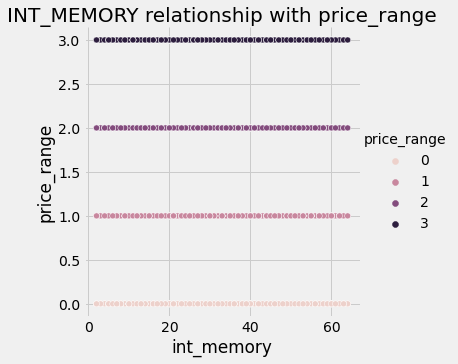

In [ ]:
for x in price_range_corr_top[1:].index:
    dsimp.relation_diagram(x, 'price_range', data_train)

# 4. Feature selecction y engenieering


In [ ]:
# Se separ entre variables destino y explicativas
X = data_train.drop('price_range', axis = 1)
y = data_train['price_range']

In [ ]:
# Se divide el data set para el entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 1)

## Regresión Lineal 

In [ ]:
# Se instancia el modelo
lr = LinearRegression()
# Se fitea el modelo
lr.fit(X_train, y_train)
# Se evalua el modelo
lr_Range = lr.predict(X_test)
lr_Score = lr.score(X_test, y_test)
lr_Mae = mean_absolute_error(y_test, lr_Range)
print('score RL: ', lr_Score)
print('promedio de error absoluto RL', lr_Mae)

score RL:  0.9077139501473082
promedio de error absoluto RL 0.28492595697333567


### Decision Tree Regression

In [ ]:
# Se instancia el modelo
dt = DecisionTreeRegressor(max_leaf_nodes=200, random_state = 1)
# Se fitea el modelo
dt.fit(X_train, y_train)
# Prediccion
dt_range = dt.predict(X_test)
# Evaluación del modelo
dt_score = dt.score(X_test, y_test)
dt_Mae = mean_absolute_error(y_test, dt_range)
print('score DT: ', dt_score)
print('promedio de error absoluto DT', dt_Mae)

score DT:  0.8604114826728166
promedio de error absoluto DT 0.1725


### Decision Tree Classifier


In [ ]:
# Se instancia el modelo
dtc = DecisionTreeClassifier(max_leaf_nodes=200,random_state = 1)
# Se fitea el modelo
dtc.fit(X_train, y_train)
# Se predice el modelo
dtc_range = dtc.predict(X_test)
# Se evalua el modelo
dtc_score = dtc.score(X_test, y_test)
dtc_mae = mean_absolute_error(y_test, dtc_range)
print('score DT: ', dtc_score)
print('promedio de error absoluto DT', dtc_mae)

score DT:  0.8475
promedio de error absoluto DT 0.1525


### Random Forest



In [ ]:
# Se instancia el modelo
rf = RandomForestRegressor()
# Se fitea el modelo
rf.fit(X_train, y_train)
# Se predice el modelo
rf_range = rf.predict(X_test)
# Se evalua el modelo
rf_score = rf.score(X_test,y_test)
rf_mae = mean_absolute_error(y_test, rf_range)
print('score RF: ', rf_score)
print('promedio de error absoluto RF', rf_mae)

score RF:  0.9365432623252614
promedio de error absoluto RF 0.178475


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Se instancia el modelo
knn = KNeighborsClassifier(n_neighbors=4)
# Se fitea el modelo
knn.fit(X_train, y_train)
# Se predice el modelo
knn_range = knn.predict(X_test)
# Se evalua el modelo
knn_score = knn.score(X_test,y_test)
knn_mae = mean_absolute_error(y_test, rf_range)
print('score KNN: ', knn_score)
print('promedio de error absoluto KNN', knn_mae)



score KNN:  0.8925
promedio de error absoluto KNN 0.178475


In [ ]:
error_rate = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

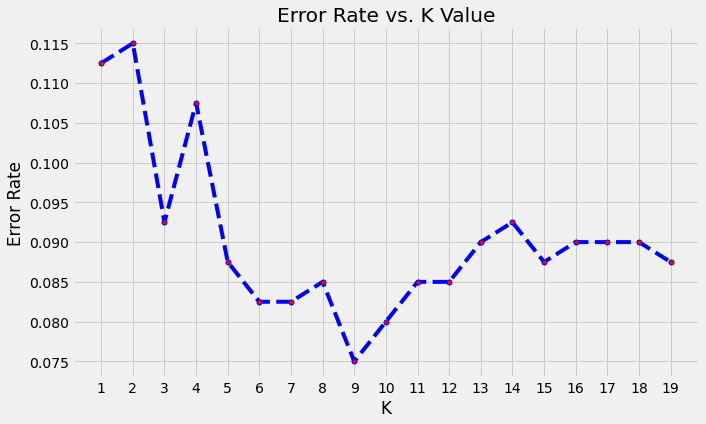

In [ ]:
plt.figure(figsize=(10,6))
plt.xticks([x for x in range(21)])
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# Se instancia el modelo
knn = KNeighborsClassifier(n_neighbors=9)
# Se fitea el modelo
knn.fit(X_train, y_train)
# Se predice el modelo
knn_range = knn.predict(X_test)
# Se evalua el modelo
knn_score = knn.score(X_test,y_test)
knn_mae = mean_absolute_error(y_test, rf_range)
print('score KNN: ', knn_score)
print('promedio de error absoluto KNN', knn_mae)

score KNN:  0.925
promedio de error absoluto KNN 0.178475


-----------

# CON SELECCION DE VARIABLES

In [ ]:
# Se separ entre variables destino y explicativas
X = data_train[price_range_corr_top.index].drop('price_range', axis = 1)
y = data_train['price_range']

In [ ]:
# Se divide el data set para el entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 1)

In [ ]:
# Se instancia el modelo
lr = LinearRegression()
# Se fitea el modelo
lr.fit(X_train, y_train)
# Se evalua el modelo
lr_Range = lr.predict(X_test)
lr_Score = lr.score(X_test, y_test)
lr_Mae = mean_absolute_error(y_test, lr_Range)
print('score RL: ', lr_Score)
print('promedio de error absoluto RL', lr_Mae)

score RL:  0.9089734582451858
promedio de error absoluto RL 0.28137926908735283


### Decision Tree Regression

In [ ]:
# Se instancia el modelo
dt = DecisionTreeRegressor(max_leaf_nodes=200, random_state = 1)
# Se fitea el modelo
dt.fit(X_train, y_train)
# Prediccion
dt_range = dt.predict(X_test)
# Evaluación del modelo
dt_score = dt.score(X_test, y_test)
dt_Mae = mean_absolute_error(y_test, dt_range)
print('score DT: ', dt_score)
print('promedio de error absoluto DT', dt_Mae)

score DT:  0.878618680585058
promedio de error absoluto DT 0.15


### Decision Tree Classifier


In [ ]:
# Se instancia el modelo
dtc = DecisionTreeClassifier(max_leaf_nodes=200,random_state = 1)
# Se fitea el modelo
dtc.fit(X_train, y_train)
# Se predice el modelo
dtc_range = dtc.predict(X_test)
# Se evalua el modelo
dtc_score = dtc.score(X_test, y_test)
dtc_mae = mean_absolute_error(y_test, dtc_range)
print('score DT: ', dtc_score)
print('promedio de error absoluto DT', dtc_mae)

score DT:  0.865
promedio de error absoluto DT 0.135


### Random Forest



In [ ]:
# Se instancia el modelo
rf = RandomForestRegressor()
# Se fitea el modelo
rf.fit(X_train, y_train)
# Se predice el modelo
rf_range = rf.predict(X_test)
# Se evalua el modelo
rf_score = rf.score(X_test,y_test)
rf_mae = mean_absolute_error(y_test, rf_range)
print('score RF: ', rf_score)
print('promedio de error absoluto RF', rf_mae)

score RF:  0.9441091622665938
promedio de error absoluto RF 0.15910000000000002


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Se instancia el modelo
knn = KNeighborsClassifier(n_neighbors=4)
# Se fitea el modelo
knn.fit(X_train, y_train)
# Se predice el modelo
knn_range = knn.predict(X_test)
# Se evalua el modelo
knn_score = knn.score(X_test,y_test)
knn_mae = mean_absolute_error(y_test, rf_range)
print('score KNN: ', knn_score)
print('promedio de error absoluto KNN', knn_mae)



score KNN:  0.8925
promedio de error absoluto KNN 0.15910000000000002


In [ ]:
error_rate = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

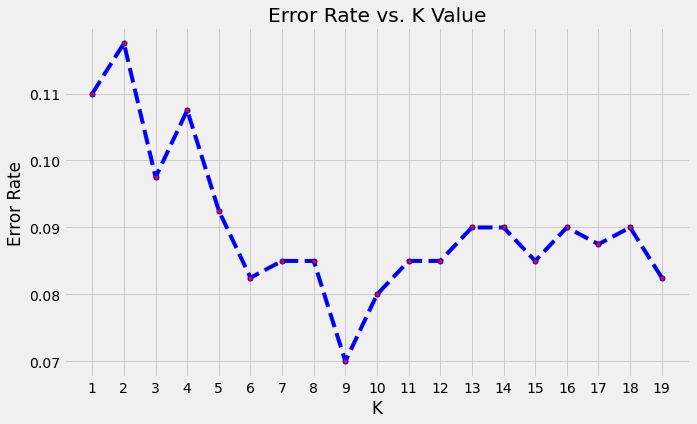

In [ ]:
plt.figure(figsize=(10,6))
plt.xticks([x for x in range(21)])
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# Se instancia el modelo
knn = KNeighborsClassifier(n_neighbors=9)
# Se fitea el modelo
knn.fit(X_train, y_train)
# Se predice el modelo
knn_range = knn.predict(X_test)
# Se evalua el modelo
knn_score = knn.score(X_test,y_test)
knn_mae = mean_absolute_error(y_test, rf_range)
print('score KNN: ', knn_score)
print('promedio de error absoluto KNN', knn_mae)

score KNN:  0.93
promedio de error absoluto KNN 0.15910000000000002
